
# How to Create an N-Gram Model from Scratch

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023 / REVISED: 2 February 2024
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

**Revision Notes:**

This version corrects the construction of the ngrams by ensuring that the target word -- the word predicted by the history -- is properly represented with sentence paddings.

Also, in the computation of conditional probababilites, the propery smoothing formula is applied, where the denominator is augmented by the a factor of the vocabulary length, not the square or cube for bigrams and ngrams respectively.

The problems of the previous notebook are corrected by focusing on the representation of the target word.

# Pattern

1. Import corpus &rarr; `TOKEN`, `VOCAB`.
2. Extract ngrams from training tokens &rarr; `NGRAM`.
3. Count ngrams and convert to models &rarr; `MODEL`.
4. Convert test sentences into tokens &rarr; `TEST_SENT`, `TEST_TOKEN`.
5. Extract ngrams from test tokens &rarr; `TEST_NGRAM`.
6. Test model by joining model information `M.i` to `TEST_NGRAM` and then summing i per sentence &rarr; `TEST_NGRAM'`, `TEST_SENT'`.
7. Compute model perplexity by exponentiating mean information. 

# Set Up Environment

In [1]:
import pandas as pd
import numpy as np

In [2]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_dir = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']

In [3]:
output_dir

'/Users/rca2t1/Dropbox/Courses/DS/DS5001/DS5001_2024_01_R/output'

In [4]:
ngram_order = 3
widx = [f"w{i}" for i in range(ngram_order)]

In [5]:
widx

['w0', 'w1', 'w2']

# Get Some Training Data

In [6]:
data_dir = output_dir
OHCO = ['book_id','chap_num','para_num','sent_num','token_num']

In [7]:
TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [8]:
TOKEN.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        0        0        0               Sir       sir
                                   1            Walter    walter
                                   2            Elliot    elliot
                                   3                of        of
                                   4          Kellynch  kellynch

In [9]:
VOCAB.head()

,n
term_str,
1,3
15,1
16,1
1760,1
1784,1


# Select OOV terms

For our OOV terms, we select very short words that appear only once.

This is just one way to handle OOV terms.

In [10]:
VOCAB['n_chars'] = VOCAB.index.str.len()
VOCAB['modified_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modified_term_str'] = "<UNK>"

We apply the modified term list to our tokens.

In [11]:
TOKEN['modified_term_str'] = TOKEN.term_str.map(VOCAB.modified_term_str)

In [12]:
TOKEN[TOKEN.modified_term_str == '<UNK>'].sample(5)

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
1       1        18       1        8                 Z        z   
2       39       19       13       11                L        l   
1       21       71       4        13               Wm       wm   
        23       40       2        0                 E        e   
2       40       17       1        1                ho       ho   

                                             modified_term_str  
book_id chap_num para_num sent_num token_num                    
1       1        18       1        8                     <UNK>  
2       39       19       13       11                    <UNK>  
1       21       71       4        13                    <UNK>  
        23       40       2        0                     <UNK>  
2       40       17       1        1                     <UNK>

# Generate NGram Models

Here, we want to take our list of modified tokens and add sentence boundary symbols `<s>` and `</s>` before and after each sentence.

Then we want to bind offset versions of the this token list into a dataframe with as many columns as our ngram is wide.

So, for example, for a trigram table representing the novle _Emma_, we want something like this:

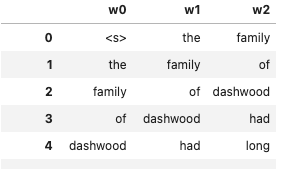

Note how each succussive column is the same data but shifted up one row.

Note also that this table contains all the data required to count instances of trigrams and all lower-order n-grams, i.e. bigram and unigram.

## Prepare tokens for ngram binding

In [13]:
def token_to_padded(token, grouper=['sent_num'], term_str='term_str'):
    ohco = token.index.names # We preserve these since they get lost in the shuffle'
    padded = token.groupby(grouper)\
        .apply(lambda x: '<s> ' + ' '.join(x[term_str]) + ' </s>')\
        .apply(lambda x: pd.Series(x.split()))\
        .stack().to_frame('term_str')
    padded.index.names = ohco
    return padded

In [14]:
PADDED = token_to_padded(TOKEN, grouper=OHCO[:4], term_str='modified_term_str')
PADDED = PADDED.unstack().reset_index(drop=True).stack().dropna()
PADDED.index.names = ['sent_num', 'token_num']

In [15]:
VOCAB2 = PADDED.term_str.value_counts().to_frame('n')

In [16]:
PADDED.head()

term_str
sent_num token_num         
0        0              <s>
         1              sir
         2           walter
         3           elliot
         4               of

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

Now we concatenate a set of offset versions of our token list. 

We use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

Then we use the `pd.concat()` method to bind our offset token lists.

In [17]:
def padded_to_ngrams(padded, grouper=['sent_num'], n=2):

    ohco = padded.index.names # This gets lost in the grouping
    G = padded.groupby(grouper)
    ng = [None for i in range(ngram_order)]
    for i in range(ngram_order):
        if i == 0:
            ng[0] = G.apply(lambda x: x)
        else:
            ng[i] = G.apply(lambda x: pd.concat([x.shift(i) for i in range(i,-1,-1)], axis=1))
        ng[i].columns = widx[:i+1]    
        ng[i] = ng[i].reset_index(drop=True)
        ng[i].index = padded.index
        ng[i] = ng[i].fillna('</s>')
            
    return ng

In [18]:
NG = padded_to_ngrams(PADDED, n=ngram_order)

In [19]:
sid = 5

In [20]:
NG[0].loc[sid]

,w0
token_num,
0,<s>
1,this
2,was
3,the
4,page
5,at
6,which
7,the
8,favourite


In [21]:
NG[1].loc[sid]

,w0,w1
token_num,,
0,</s>,<s>
1,<s>,this
2,this,was
3,was,the
4,the,page
5,page,at
6,at,which
7,which,the
8,the,favourite


In [22]:
NG[2].loc[sid]

,w0,w1,w2
token_num,,,
0,</s>,</s>,<s>
1,</s>,<s>,this
2,<s>,this,was
3,this,was,the
4,was,the,page
5,the,page,at
6,page,at,which
7,at,which,the
8,which,the,favourite


## Generate models

Next we create a list of models. 

Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. 

We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [23]:
def ngrams_to_models(ngrams, k=.01):

    model = [None for i in range(ngram_order)]
    K = len(VOCAB2) * k
    
    for i in range(ngram_order):    
        if i == 0:
            model[i] = ngrams[i].value_counts().to_frame('n')
            model[i]['p'] = (model[i].n + k) / (model[i].n.sum() + K)
            model[i]['i'] = np.log2(1/model[i].p)
        else:
            model[i] = ngrams[i].value_counts().to_frame('n')
            model[i]['cp'] = (model[i].n + k) / (model[i-1].n + K)
            model[i]['i'] = np.log2(1/model[i].cp)
        model[i] = model[i].sort_index()
            
    return model

In [24]:
M = ngrams_to_models(NG)

**Models from Matrices**

We could create our models this way.

This helps us see what we are doing when computing conditional probabilities.

However, this is slow.

In [25]:
def ngrams_to_matrix_models(ngrams, k=.01):
    M = [None for i in range(ngram_order)]
    for i in range(ngram_order):
        M[i] = NG[i].value_counts()
        if i > 0:
            M[i] = M[i].unstack(fill_value=0).T + k
        else:
            M[i] = M[i].to_frame('i')
        M[i] = M[i] / M[i].sum()
        M[i] = -np.log2(M[i])        
    return M

In [26]:
MM = ngrams_to_matrix_models(NG)

In [27]:
MM[2]

w0                 1                             1760       1784       1800  \
w1              1760       1785       ends    married  elizabeth         he   
w2                                                                            
1          13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1760       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1784       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1785       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1787       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
...              ...        ...        ...        ...        ...        ...   
youth      13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
youthful   13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zeal       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zealous    13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zealously  13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   

w0              1810       1814        200       29th  ...       zeal  \
w1           charles    wearing      <UNK>         of  ...         in   
w2                                                     ...              
1          13.023581  13.023581  13.023581  13.023581  ...  13.023581   
1760       13.023581  13.023581  13.023581  13.023581  ...  13.023581   
1784       13.023581  13.023581  13.023581  13.023581  ...  13.023581   
1785       13.023581  13.023581  13.023581  13.023581  ...  13.023581   
1787       13.023581  13.023581  13.023581  13.023581  ...  13.023581   
...              ...        ...        ...        ...  ...        ...   
youth      13.023581  13.023581  13.023581  13.023581  ...  13.023581   
youthful   13.023581  13.023581  13.023581  13.023581  ...  13.023581   
zeal       13.023581  13.023581  13.023581  13.023581  ...  13.023581   
zealous    13.023581  13.023581  13.023581  13.023581  ...  13.023581   
zealously  13.023581  13.023581  13.023581  13.023581  ...  13.023581   

w0                                            zealous                        \
w1                of         to       with  affection  attention    officer   
w2                                                                            
1          13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1760       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1784       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1785       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
1787       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
...              ...        ...        ...        ...        ...        ...   
youth      13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
youthful   13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zeal       13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zealous    13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   
zealously  13.023581  13.023581  13.023581  13.023581  13.023581  13.023581   

w0                    zealously              
w1                on     active discharging  
w2                                           
1          13.023581  13.023581   13.023581  
1760       13.023581  13.023581   13.023581  
1784       13.023581  13.023581   13.023581  
1785       13.023581  13.023581   13.023581  
1787       13.023581  13.023581   13.023581  
...              ...        ...         ...  
youth      13.023581  13.023581   13.023581  
youthful   13.023581  13.023581   13.023581  
zeal       13.023581  13.023581   13.023581  
zealous    13.023581  13.023581   13.023581  
zealously  13.023581  13.023581   13.023581  

[8227 rows x 75442 columns]

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [28]:
def sentence_to_token(sent_list, file=True):
    
    # Convert list of sentences to dataframe
    if file:
        S = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
    else:
        S = pd.DataFrame(sent_list, columns=['sent_str'])
    S.index.name = 'sent_num'
    
    # Convert dataframe of sentences to TOKEN with normalized terms
    K = S.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
    K['term_str'] = K.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
    K.index.names = ['sent_num', 'token_num']
    
    return S, K

In [29]:
TEST_SENTS, TEST_TOKENS = sentence_to_token("test_sentences.txt")

In [30]:
TEST_SENTS.head()

,sent_str
sent_num,
0,the quick brown fox jumped over the lazy dogs
1,The event had every promise of happiness for h...
2,Mr Weston was a man of unexceptionable charact...
3,ChatGPT is not the singularity
4,but it was a black morning's work for her


In [31]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               the      the
         1             quick    quick
         2             brown    brown
         3               fox      fox
         4            jumped   jumped

## Identify OOV terms

Create a Series of OOV terms from our unigram model.

This could be included in our function.

In [32]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(VOCAB2.index), 'term_str'] = "<UNK>"

In [33]:
TEST_TOKENS

token_str  term_str
sent_num token_num                    
0        0               the       the
         1             quick     quick
         2             brown     brown
         3               fox       fox
         4            jumped    jumped
...                      ...       ...
42       9              give      give
         10              her       her
         11         pleasant  pleasant
         12          society   society
         13            again     again

[436 rows x 2 columns]

In [34]:
TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

token_str
Weston            2
ChatGPT           1
Hartfield         1
Isabella          1
Isabella's        1
Woodhouse         1
childhood         1
illnesses         1
intellectual      1
lazy              1
tenderer          1
valetudinarian    1
Name: count, dtype: int64

## Convert test tokens into ngrams

Use offset and bind method using `pd.concat()` and `df.shift(0)`, as above.

In [35]:
TEST_PADDED = token_to_padded(TEST_TOKENS)

In [36]:
TEST_PADDED

term_str
sent_num token_num          
0        0               <s>
         1               the
         2             quick
         3             brown
         4               fox
...                      ...
42       11              her
         12         pleasant
         13          society
         14            again
         15             </s>

[522 rows x 1 columns]

In [37]:
TEST_NG = padded_to_ngrams(TEST_PADDED, 'sent_num', ngram_order)

In [38]:
TEST_NG[0]

w0
sent_num token_num          
0        0               <s>
         1               the
         2             quick
         3             brown
         4               fox
...                      ...
42       11              her
         12         pleasant
         13          society
         14            again
         15             </s>

[522 rows x 1 columns]

## Bind the models to test data

We add our model data to the test data as a set of features.

In [39]:
def test_model(model, ngrams, sents):
        
    n = len(model)
    ohco = ngrams[0].index.names
    
    max_i = np.log2(len(M[0])) # For unseen combos
    
    R = []
    for i in range(n):

        cols = widx[:i+1]
            
        T = ngrams[i].merge(M[i], on=cols, how='left')
        T.index = ngrams[i].index
        T = T.reset_index().set_index(ohco + cols).i
        
        # This how we handle unseen combos
        T[T.isna()] = max_i

        R.append(T.to_frame(f"i{i}"))
                
    return R

In [40]:
R = test_model(M, TEST_NG, TEST_SENTS)

# Sentence Perplexity

In [41]:
pp_cols = []
mean_i_cols = []
for i in range(ngram_order):
    pp_col = f"pp{i}"
    mean_i_col = f"mean_i_{i}"
    pp_cols.append(pp_col)
    mean_i_cols.append(mean_i_col)
    TEST_SENTS[mean_i_col] = R[i].groupby('sent_num')[f"i{i}"].mean()
    TEST_SENTS[f"pp{i}"] = np.exp2(TEST_SENTS[mean_i_col])

In [42]:
TEST_SENTS.sort_values("pp1").style.background_gradient(cmap="YlGnBu", axis=0)

,sent_str,mean_i_0,pp0,mean_i_1,pp1,mean_i_2,pp2
sent_num,,,,,,,
28,but he was no companion for her,6.913153,120.521986,4.467849,22.128727,8.233200,300.912365
27,She dearly loved her father,8.685049,411.585617,5.280647,38.871676,10.774915,1752.155843
23,only half a mile from them,8.129131,279.970494,5.437128,43.324994,8.822603,452.760241
11,but the intercourse of the last seven years,7.938343,245.289734,5.773689,54.708349,9.303555,631.900993
15,knowing all the ways of the family,7.648545,200.651078,5.830534,56.907002,9.639227,797.436891
19,and who had such an affection for her as could never find fault,8.054469,265.850148,6.120900,69.594436,9.523509,735.972757
33,for having been a valetudinarian all his life,7.939611,245.505442,6.189385,72.977778,10.067731,1073.220295
21,It was true that her friend was going only half a mile from them,8.141286,282.339316,6.269960,77.169583,8.870667,468.098223
24,and a Miss Taylor in the house,7.390984,167.844809,6.460568,88.069349,9.383327,667.825268


# Model Perplexity

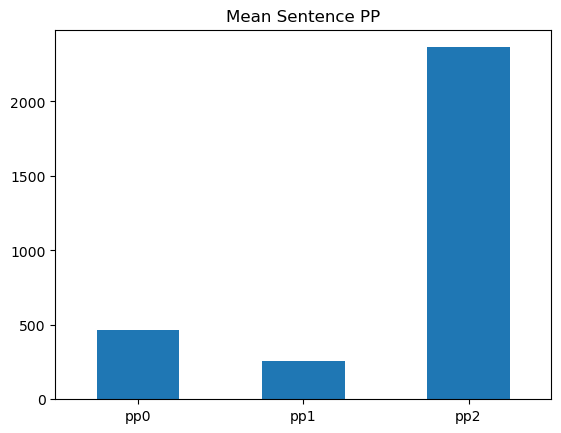

In [43]:
TEST_SENTS[pp_cols].mean(numeric_only=True).plot.bar(rot=0, title="Mean Sentence PP");

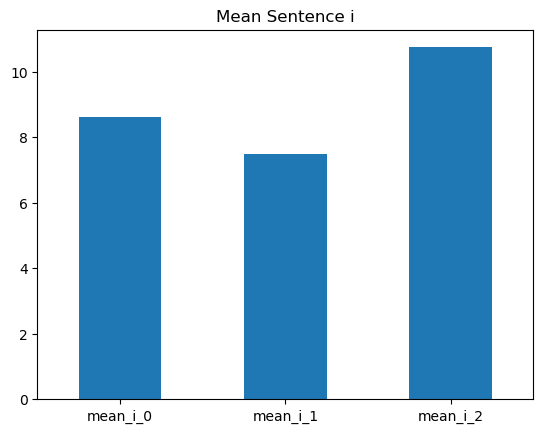

In [44]:
TEST_SENTS[mean_i_cols].mean(numeric_only=True).plot.bar(rot=0, title="Mean Sentence i");

In [45]:
MP = pd.DataFrame([(np.exp2(R[i][f"i{i}"].mean()), R[i][f"i{i}"].mean()) for i in range(ngram_order)], columns=['pp','mean_i'])

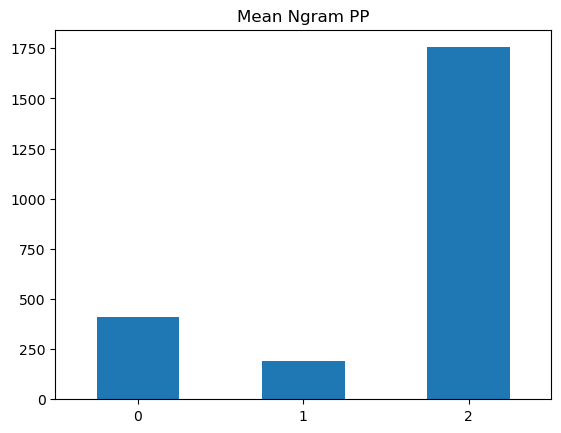

In [46]:
MP.pp.plot.bar(rot=0, title="Mean Ngram PP");

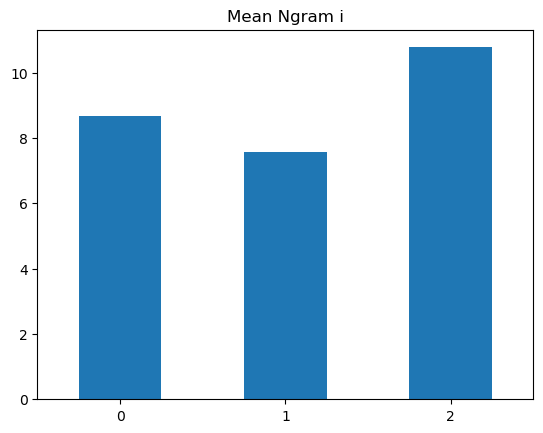

In [47]:
MP.mean_i.plot.bar(rot=0, title="Mean Ngram i");

# Visualize

In [48]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '').str.replace(' </s>', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()

In [49]:
Z['pp_mean'] = Z.mean(axis=1) # Just for sorting purposes

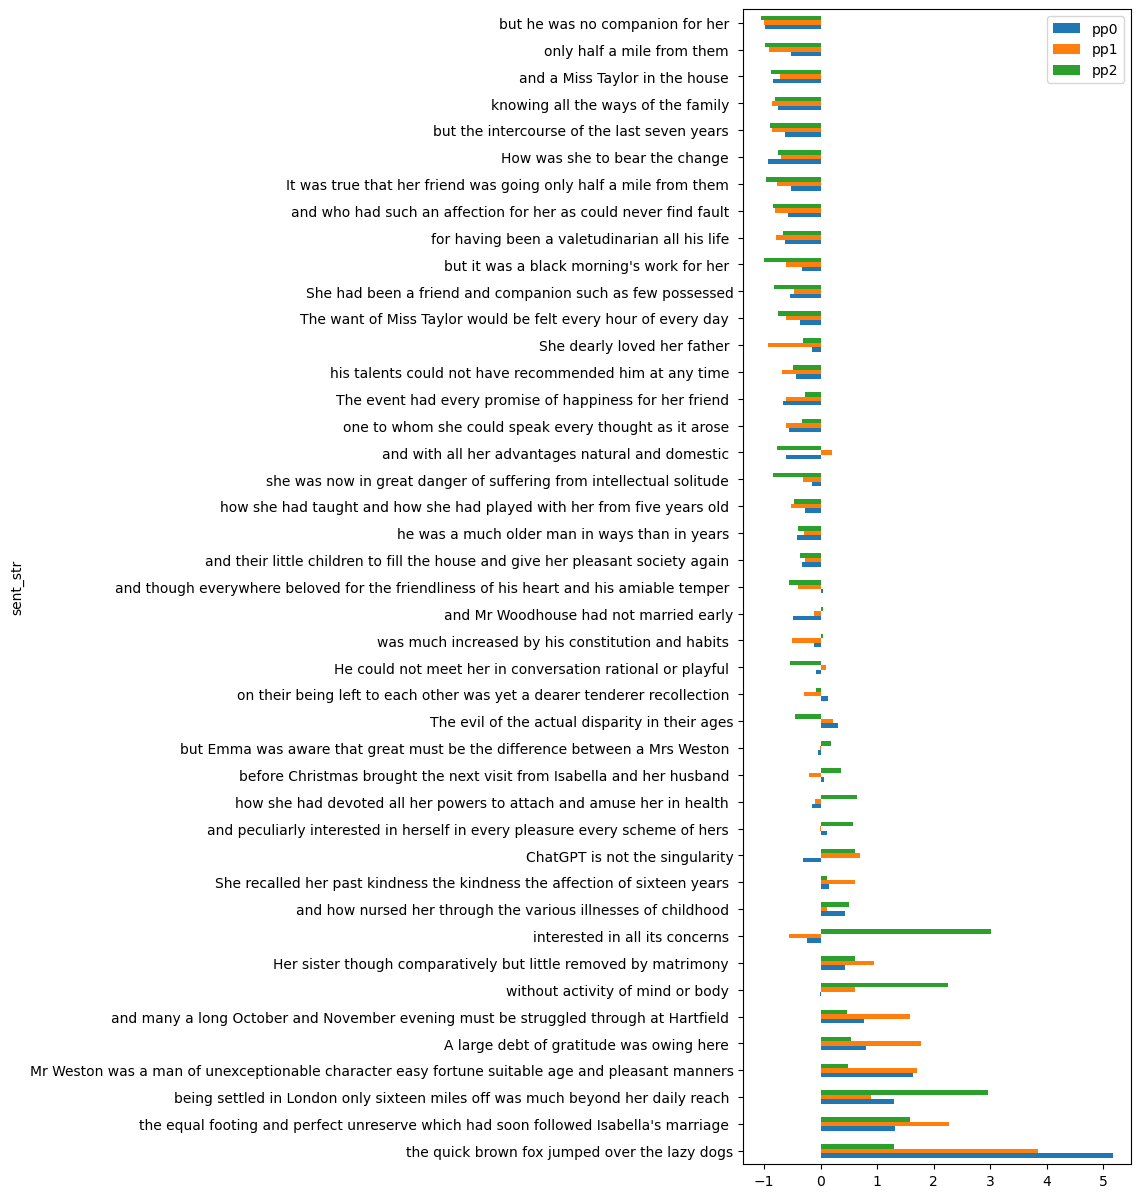

In [50]:
Z.sort_values('pp_mean', ascending=False)[['pp0','pp1','pp2']].plot.barh(figsize=(5,15));

# Generate Text

In [51]:
def generate_text(M, n=250):
    
    if len(M) < 3:
        raise ValueError("Must have trigram model generated.")
        
    words = ['</s>', '<s>']
    
    for i in range(n):
        
        bg = tuple(words[-2:])

        # Try trigram model
        try:
            next_word = M[2].loc[bg].sample(weights='cp').index[0]

        # If not found in model, back off to bigram model
        except KeyError as e1:
            # print(bg)
            try:
                # Get the last word in the bigram
                ug = bg[1]
                next_word = M[1].loc[ug].sample(weights='cp').index[0]
            
            # ... back off to unigram
            except KeyError as e2:
                # print(ug)
                next_word = M[0].sample(weights='p').index[0][0]
        
        words.append(next_word)
    
    text = ' '.join(words[2:])
    print('\n'.join([f"{i+1}. " +  line.replace('</s> <s>','').replace('<s>', '').strip().upper() 
                       for i, line in enumerate(text.split('</s>'))]))

In [52]:
generate_text(M)

1. BUT THIS WAS A VAIN IDEA
2. SMITH S ANSWER AND A SECRET GRATIFICATION TO HERSELF TO THIS FORMIDABLE MOTHER IN LAW AND HIS MANNERS WERE AS DIFFERENT AS THEIR MOTHER BY REPRESENTING THE INCONVENIENCES WHICH THAT INDULGENT MOTHER MUST BE TALKED OF GOING
3. JENNINGS ON HER ACCOUNT I HAVE NOW KNOWN IT I KNOW YOUR FRIENDSHIP
4. BRANDON WILL BE INSURED IMMEDIATELY BY ANY JUST APPRECIATION OR REAL TASTE
5. CRIED ELINOR
6. SHE WOULD SETTLE THE MATTER I AM SURE I HAVE DECLARED
7. SAID MRS
8. THERE MIGHT BE AND THEY WERE NOW HUNTING FOR THE FIRST BLACK IDEA
9. SMITH WHEN I WAS WILLING TO SHEW SUCH PLEASURE AS A COMPANION
10. SHE COULD NOT BEAR TO HAVE BEEN THINKING OF BETTY S SISTER MY DEAR
11. AND WAS DELIGHTED TO BE READY
12. YOUR WIFE HAS A RIGHT TO REPEAT HALF THAT WAS WORTH HEARING AND HIS MANNERS TOWARDS THEM
13. FOR YOU ARE
14. IF YOU WILL ALWAYS BE GLAD TO BURST THEIR USUAL WALK TO KEEP HER THERE AND IT WAS THEN ABOUT THREE THOUSAND POUNDS OF HIS EYES HAD CAUGHT HER EAR HURRIED INTO TH